In [1]:
from drive.MyDrive.datas.module.preprocess import *
from drive.MyDrive.datas.module.setting_tf import *
from drive.MyDrive.datas.module.visualization import *

In [2]:
dataset = get_dataset()
print(dataset.shape)
dataset.head(2)

(10051, 3)


,image_path,status,where
0,/content/Dataset/valid/photos/3f1c06fa3588c2ab...,photos,valid
1,/content/Dataset/valid/photos/6b5a1bdd41b6b158...,photos,valid


In [3]:
datas = split_train_valid_df(dataset=dataset, img_size=224, shuffle=True)

In [4]:
print(f'Shape >> train_dataframe :{datas["train_df"].shape} \n\t valiation_dataframe :{datas["valid_df"].shape}')

Shape >> train_dataframe :(7041, 2) 
	 valiation_dataframe :(3010, 2)


In [5]:
X_train, y_train, X_valid, y_valid = split_X_y_dataset(datas=datas)

In [6]:
print(f"Shape >> X_train :{X_train.shape}, y_train :{y_train.shape} \n\t X_valid :{X_valid.shape}, y_valid :{y_valid.shape}")

Shape >> X_train :(7041, 224, 224, 3), y_train :(7041,) 
	 X_valid :(3010, 224, 224, 3), y_valid :(3010,)


In [7]:
# MinMaxScaling
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [8]:
import tensorflow as tf

In [9]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [10]:
datas, X_train, y_train, X_valid, y_valid = None, None, None, None, None

train_batches = train.shuffle(len(train)).batch(32)
valid_batches = valid.shuffle(len(valid)).batch(32)

In [ ]:
# for image_batch, label_batch in train_batches.take(1):
#   pass

# image_batch.shape

TensorShape([32, 224, 224, 3])

In [11]:
base_model = load_base_model("mobilenet", input_shape=(224, 224, 3), trainable=False)

In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,431,265
Trainable params: 173,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
monitor_ls = ["val_accuracy", "val_loss"]
callbacks = setting_callback("mobile", monitors=monitor_ls, min_delta=0.0001, acc_patience=10, loss_patience=7)

In [ ]:
history = model.fit(train_batches, epochs=150, validation_data=valid_batches, verbose=1,
                    callbacks=callbacks)

Epoch 1/150
221/221 [==============================] - 45s 94ms/step - loss: 0.4835 - accuracy: 0.7718 - val_loss: 0.3448 - val_accuracy: 0.8568

Epoch 00001: val_accuracy improved from -inf to 0.85681, saving model to /content/drive/MyDrive/datas/model_result/mobile_acc.h5

Epoch 00001: val_loss improved from inf to 0.34484, saving model to /content/drive/MyDrive/datas/model_result/mobile_loss.h5
Epoch 2/150
221/221 [==============================] - 25s 88ms/step - loss: 0.3326 - accuracy: 0.8598 - val_loss: 0.3049 - val_accuracy: 0.8781

Epoch 00002: val_accuracy improved from 0.85681 to 0.87807, saving model to /content/drive/MyDrive/datas/model_result/mobile_acc.h5

Epoch 00002: val_loss improved from 0.34484 to 0.30488, saving model to /content/drive/MyDrive/datas/model_result/mobile_loss.h5
Epoch 3/150
221/221 [==============================] - 27s 88ms/step - loss: 0.2919 - accuracy: 0.8803 - val_loss: 0.2897 - val_accuracy: 0.8837

Epoch 00003: val_accuracy improved from 0.878

In [ ]:
max_acc_idx = np.argmax(history.history['val_accuracy'])
print(f'MAX Acc model >> Acc :{history.history["val_accuracy"][max_acc_idx]}, Loss :{history.history["val_loss"][max_acc_idx]}')

min_loss_idx = np.argmin(history.history['val_loss'])
print(f'MIN Loss model >> Acc :{history.history["val_accuracy"][min_loss_idx]}, Loss :{history.history["val_loss"][min_loss_idx]}')

MAX Acc model >> Acc :0.89435213804245, Loss :0.27653154730796814
MIN Loss model >> Acc :0.8933554887771606, Loss :0.2691862881183624


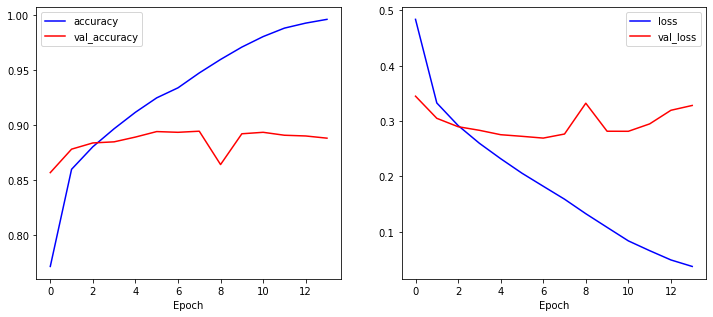

In [ ]:
make_scores_graph(history=history)

In [13]:
model.load_weights("/content/drive/MyDrive/datas/model_result/mobilenet_loss.h5")

In [14]:
for valid_batch, label_batch in valid_batches.take(1):
  pass

valid_batch.shape

TensorShape([32, 224, 224, 3])

In [15]:
predictions = model.predict(valid_batch)
predictions = predictions.squeeze(-1)
predictions

array([0.9951283 , 0.09029666, 0.06322508, 0.9706252 , 0.0114643 ,
       0.9163678 , 0.00580939, 0.99110186, 0.03896326, 0.05047451,
       0.04006607, 0.01301295, 0.8056199 , 0.00296443, 0.00118971,
       0.53757715, 0.01930197, 0.72069657, 0.9420742 , 0.89971626,
       0.47701368, 0.67315227, 0.59769386, 0.9291076 , 0.994144  ,
       0.23440629, 0.09136775, 0.5817775 , 0.01899137, 0.20144437,
       0.00509054, 0.8894122 ], dtype=float32)

In [16]:
def classify(x):
  result = 1 if x >= 0.5 else 0
  
  return result

In [17]:
pred_label = [classify(data) for data in predictions]
print(pred_label)

[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


In [ ]:
label_batch.numpy()

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

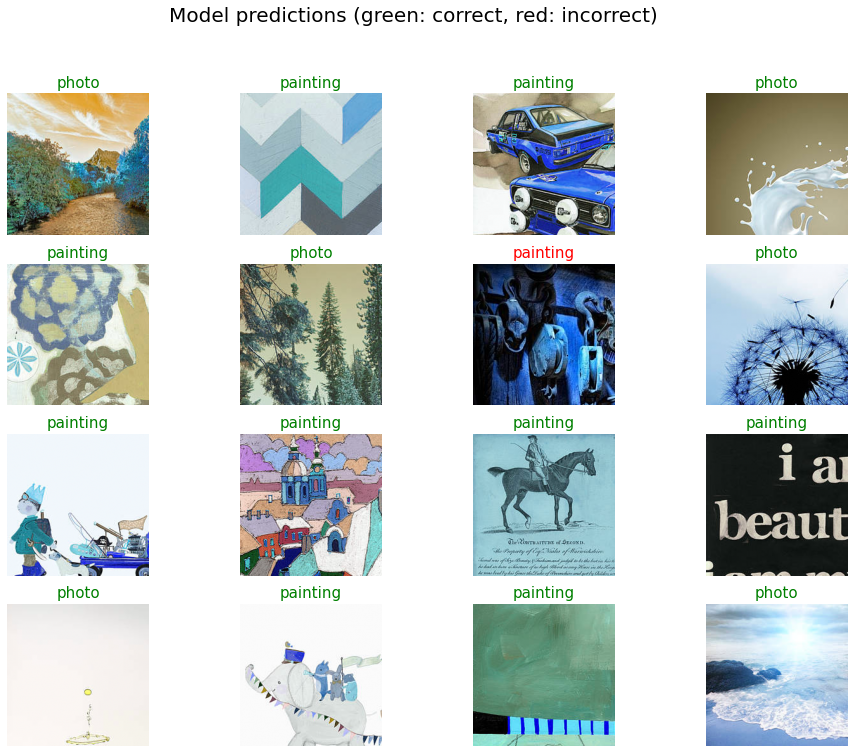

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(16, 12))

num = 0
for row in range(4):
  for col in range(4):
    ax[row, col].axis("off")
    ax[row, col].imshow(valid_batch[num])
    color = "green" if pred_label[num] == label_batch.numpy()[num] else "red"
    title = "photo" if pred_label[num] == 1 else "painting"
    
    ax[row, col].set_title(title, fontsize=15)
    ax[row, col].title.set_color(color)
    num += 1

_ = plt.suptitle("Model predictions (green: correct, red: incorrect)", fontsize=20)
plt.show()